In [ ]:
!pip install nltk
!pip install keras
!pip install tensorflow

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pandas as pd
import nltk
from nltk import word_tokenize
nltk.download('punkt_tab')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [24]:
data_processed = pd.read_csv('tweets_preprocessed2_selected.csv')
non_suicide_data = data_processed[data_processed['class'] == 'non-suicide'].sample(n=500)
suicide_data = data_processed[data_processed['class'] == 'suicide'].sample(n=500)
balanced_data = pd.concat([non_suicide_data, suicide_data])

In [25]:
data_processed.head()
data_processed.shape

(10000, 6)

In [26]:
non_suicide_data.shape

(500, 6)

## Data Preprocessing

In [27]:
all_tokens = set(i.lower() for token in balanced_data["text"] for i in word_tokenize(token))
word_map = {token: idx for idx, token in enumerate(list(all_tokens))}
word_map['UNK'] = len(word_map)
word_map['PAD'] = len(word_map)+1

In [28]:
def text_encoder(sentence, word_map):
    tokens = word_tokenize(sentence.lower())
    encode = [word_map.get(token, word_map['UNK']) for token in tokens]
    return encode

In [29]:
class SuicideDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = sentences
        self.vocab = vocab
        self.label_mapping = {
            'non-suicide': 0,
            'suicide': 1
        }
        self.labels = [self.label_mapping[label] for label in labels]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]
        encoded_sentence = text_encoder(sentence, self.vocab)

        return {
            'input_ids': torch.tensor(encoded_sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [30]:
# Pad the input_ids to the length of the longest sequence in the batch
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['label'] for item in batch]


    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=word_map['PAD'])
    labels = torch.stack(labels)
    text_lengths = torch.tensor([len(ids) for ids in input_ids], dtype=torch.long)

    return {
        'input_ids': padded_input_ids,
        'label': labels,
        'text_length': text_lengths
    }

In [31]:
# Split data
train_data, test_data, train_label, test_label = train_test_split(
    balanced_data['text'], balanced_data['class'], test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = SuicideDataset(train_data.to_numpy(), train_label.to_numpy(), word_map)
test_dataset = SuicideDataset(test_data.to_numpy(), test_label.to_numpy(), word_map)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [47]:
train_data.shape

(800,)

## Binary-Classfication LSTM

In [10]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(vocab_size+1,embedding_dim)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid() # use sigmoid as activation function

    def forward(self,text,text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True, enforce_sorted=False)
        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)

        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        hidden = self.batch_norm(hidden)
        outputs=self.sigmoid(self.fc(self.dropout(hidden)))

        return outputs

In [ ]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 2  # suicidal/non-suicidal
n_layers = 2
bidirectional = True
dropout = 0.3

In [ ]:
model = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS GPU")
# else:
device = torch.device("cpu")
model = model.to(device)

In [20]:
def accuracy(preds, y):
    rounded_preds = torch.argmax(preds, dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [30]:
def train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].float().to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = accuracy(outputs, labels)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [22]:
def evaluate(model,loader,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            text_length = batch['text_length'].to(device)

            outputs = model(input_ids, text_length)

            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
EPOCH_NUMBER = 10
t_acc = []
t_loss = []
v_acc = []
v_loss = []

for epoch in range(1,EPOCH_NUMBER+1):

    train_loss,train_acc = train(model,train_loader,optimizer,criterion)

    valid_loss,valid_acc = evaluate(model,test_loader,criterion)

    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(valid_acc)
    v_loss.append(valid_loss)

    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

Epoch 1
	Train Loss: 0.579 | Train Acc: 70.88%
	 Val. Loss: 0.651 |  Val. Acc: 58.17%

Epoch 2
	Train Loss: 0.542 | Train Acc: 76.88%
	 Val. Loss: 0.586 |  Val. Acc: 71.15%



KeyboardInterrupt: 

In [ ]:
print("The best validation accuracy:", round(max(v_acc), 2))

The best validation accuracy: 0.83


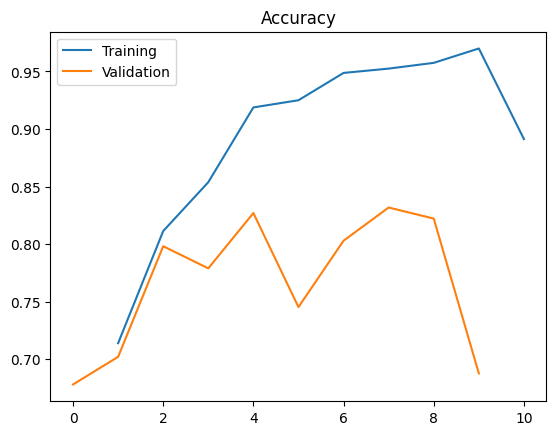

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), t_acc, v_acc)
plt.title("Accuracy")
plt.legend(("Training", "Validation"))

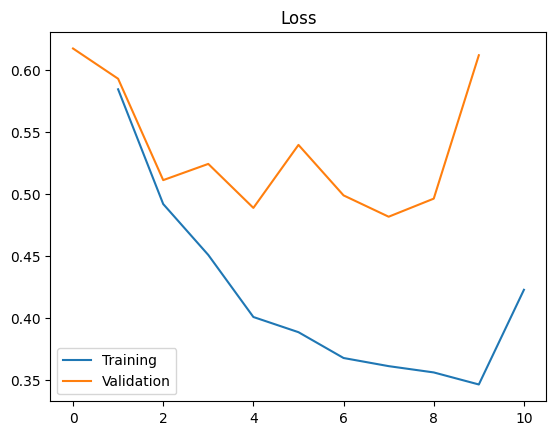

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), t_loss, v_loss)
plt.title("Loss")
plt.legend(("Training", "Validation"))

## Regression LSTM

In [1]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 1  # probability
n_layers = 2
bidirectional = True
dropout = 0.3

In [22]:
regression = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(regression.parameters(), lr=0.001)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regression = regression.to(device)

In [17]:
def re_accuracy(preds, y, threshold=0.5):
    rounded_preds = (preds > threshold).float()  # Convert probabilities to binary predictions
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [18]:
def re_train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].float().to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = re_accuracy(outputs, labels)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [19]:
def re_evaluate(model,loader,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].float().to(device)
            text_length = batch['text_length'].to(device)

            outputs = model(input_ids, text_length).squeeze(1)

            loss = criterion(outputs, labels)
            acc = re_accuracy(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
EPOCH_NUMBER = 10
t_acc = []
t_loss = []
v_acc = []
v_loss = []

for epoch in range(1,EPOCH_NUMBER+1):

    train_loss,train_acc = re_train(regression,train_loader,optimizer,criterion)

    valid_loss,valid_acc = re_evaluate(regression,test_loader,criterion)

    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(valid_acc)
    v_loss.append(valid_loss)

    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

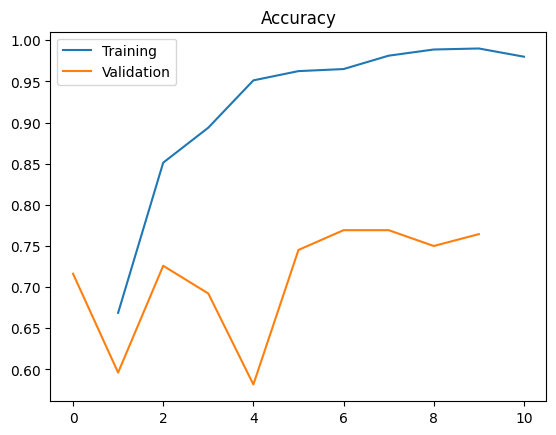

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), t_acc, v_acc)
plt.title("Accuracy")
plt.legend(("Training", "Validation"))

## LSTM with Attention Mechanism

To incorporate attention mechanism into the LSTM model, we compute attention weights over the LSTM output.

In [32]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 1  # probability
n_layers = 2
bidirectional = True
dropout = 0.3

In [33]:
import torch
import torch.nn as nn

class LSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True
        )

        # Attention layer
        self.attention = nn.Linear(hidden_dim * 2, 1)  # For attention weights
        self.softmax = nn.Softmax(dim=1)

        # Fully connected layers
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        # self.sigmoid = nn.Sigmoid()  # Use sigmoid as activation function for binary classification

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Attention mechanism
        # mask = (text_lengths.unsqueeze(1) > torch.arange(output.size(1), device=text_lengths.device)).float()
        # attn_weights = self.attention(output).squeeze(-1) * mask
        attn_weights = self.attention(output)
        attn_weights = self.softmax(attn_weights.squeeze(-1))
        # print(f"Attention Weights: ", attn_weights)

        # Context vector as weighted sum of outputs
        context = torch.bmm(attn_weights.unsqueeze(1), output).squeeze(1)  # Shape: [batch_size, hidden_dim * 2]

        # Concatenate final hidden state and context vector
        hidden = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)  # Final hidden state
        context_hidden = context + hidden  # Combine context and hidden state

        # Classification
        context_hidden = self.batch_norm(context_hidden)
        # print(f"Hidden Context shape: ", context_hidden.shape)
        # outputs = self.sigmoid(self.fc(self.dropout(context_hidden)))
        outputs = self.fc(self.dropout(context_hidden)).squeeze(1)

        return outputs


In [34]:
def accuracy_att(preds, y):
  probs = torch.sigmoid(preds)
  rounded_preds = (probs > 0.5).float()
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

In [35]:
def train_att(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].float().to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = accuracy_att(outputs, labels)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [36]:
model = LSTMWithAttention(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS GPU")
# else:
device = torch.device("cpu")
model = model.to(device)

In [37]:
def evaluate_att(model,loader,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].float().to(device)
            text_length = batch['text_length'].to(device)

            outputs = model(input_ids, text_length)

            loss = criterion(outputs, labels)
            acc = accuracy_att(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [38]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

def evaluate_att_with_metrics(model, loader, criterion):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    epoch_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].float().to(device)
            text_length = batch['text_length'].to(device)

            outputs = model(input_ids, text_length)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            all_labels.extend(labels.cpu().numpy().astype(int))
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(torch.sigmoid(outputs).cpu().numpy())

    print("Unique labels:", np.unique(all_labels))
    print("Unique predictions:", np.unique(all_preds))
    unique, counts = np.unique(all_labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print("Label distribution:", label_distribution)

    accuracy = accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"confusion matrix: ", cm)

    return {
        'loss': epoch_loss / len(loader),  # Average validation loss
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
    }

In [39]:
EPOCH_NUMBER = 10
t_acc = []
t_loss = []
v_acc = []
v_loss = []
roc_auc = []
cm = []

for epoch in range(1,EPOCH_NUMBER+1):

    train_loss,train_acc = train_att(model,train_loader,optimizer,criterion)

    valid_dict = evaluate_att_with_metrics(model,test_loader,criterion)
    valid_loss = valid_dict['loss']
    valid_acc = valid_dict['accuracy']
    roc_auc.append(valid_dict['roc_auc'])
    cm.append(valid_dict['confusion_matrix'])

    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(valid_acc)
    v_loss.append(valid_loss)

    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 96, 1: 104}
confusion matrix:  [[ 34  62]
 [  4 100]]
Epoch 1
	Train Loss: 0.578 | Train Acc: 74.38%
	 Val. Loss: 0.789 |  Val. Acc: 67.00%

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 96, 1: 104}
confusion matrix:  [[83 13]
 [25 79]]
Epoch 2
	Train Loss: 0.265 | Train Acc: 89.50%
	 Val. Loss: 0.460 |  Val. Acc: 81.00%

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 96, 1: 104}
confusion matrix:  [[84 12]
 [20 84]]
Epoch 3
	Train Loss: 0.164 | Train Acc: 94.00%
	 Val. Loss: 0.507 |  Val. Acc: 84.00%

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 96, 1: 104}
confusion matrix:  [[81 15]
 [23 81]]
Epoch 4
	Train Loss: 0.119 | Train Acc: 95.75%
	 Val. Loss: 0.513 |  Val. Acc: 81.00%

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 96, 1: 104}
confusion matrix:  [[74 22]
 [16 88]]
Epoch 5
	Train Loss: 0.067 | Trai

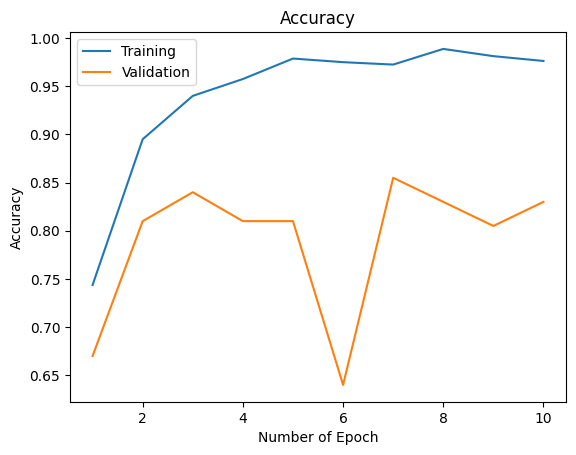

In [43]:
plt.plot(range(1, EPOCH_NUMBER+1), t_acc)
plt.plot(range(1, EPOCH_NUMBER+1), v_acc)
plt.title("Accuracy")
plt.xlabel("Number of Epoch")
plt.ylabel("Accuracy")
plt.legend(("Training", "Validation"))

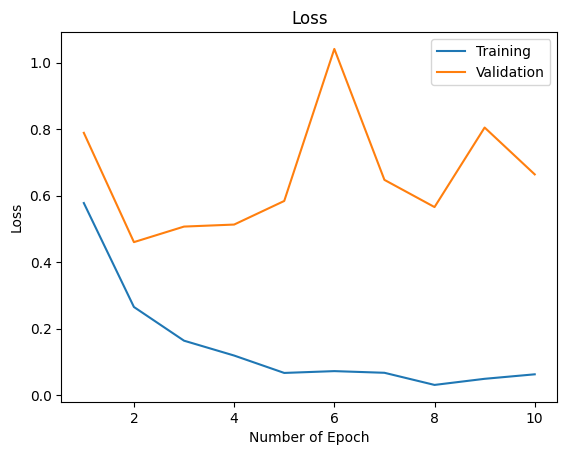

In [44]:
plt.plot(range(1, EPOCH_NUMBER+1), t_loss)
plt.plot(range(1, EPOCH_NUMBER+1), v_loss)
plt.title("Loss")
plt.xlabel("Number of Epoch")
plt.ylabel("Loss")
plt.legend(("Training", "Validation"))

The highest F1 score is 0.8711 at epoch 7


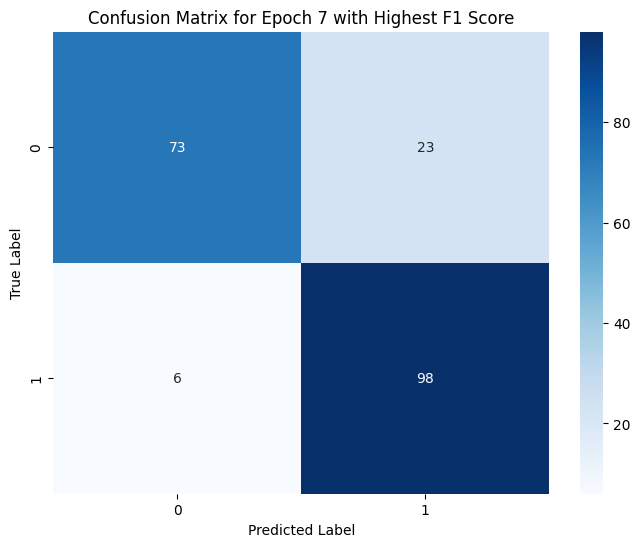

In [49]:
# plot confusion matrix with the highest F1 score
import seaborn as sns

def calculate_metrics_from_cm(cm):
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Avoid division by zero
    precision_denominator = TP + FP
    recall_denominator = TP + FN

    precision = TP / precision_denominator if precision_denominator > 0 else 0
    recall = TP / recall_denominator if recall_denominator > 0 else 0

    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

# List to store manual F1 scores
f1_scores_manual = []

# Iterate over confusion matrices
for c in cm:
    precision, recall, f1 = calculate_metrics_from_cm(c)
    f1_scores_manual.append(f1)

# Find the epoch with the highest F1 score
best_epoch_index = np.argmax(f1_scores_manual)
best_f1_score = f1_scores_manual[best_epoch_index]
best_cm = cm[best_epoch_index]

print(f"The highest F1 score is {best_f1_score:.4f} at epoch {best_epoch_index + 1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title(f'Confusion Matrix for Epoch {best_epoch_index + 1} with Highest F1 Score')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [1]:
# roc-auc curve
print(roc_auc)

NameError: name 'roc_auc' is not defined

NOT USED. Reference: https://github.com/gentaiscool/lstm-attention/tree/master

In [ ]:
import torch
import torch.nn as nn
import tensorflow as tf
from keras.layers import Layer
import keras.backend as K
from keras.initializers import glorot_uniform
from keras.regularizers import l2

# Custom Dot Product Function
def dot_product(x, kernel):
    return K.batch_dot(x, kernel, axes=[2, 0])

# AttentionWithContext and Addition Layers (As per your code)
class AttentionWithContext(Layer):
    def __init__(self, **kwargs):
        self.supports_masking = True
        self.init = glorot_uniform()
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name))
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zero',
                                 name='{}_b'.format(self.name))
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name))
        super(AttentionWithContext, self).build(input_shape)

    def call(self, x, mask=None):
        uit = dot_product(x, self.W) + self.b
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        a = K.exp(ait)

        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        return x * a

    def compute_output_shape(self, input_shape):
        return input_shape

class Addition(Layer):
    def __init__(self, **kwargs):
        super(Addition, self).__init__(**kwargs)

    def call(self, x):
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# LSTMWithAttention Incorporating the Layers
class LSTMWithAttention_New(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMWithAttention_New, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True
        )
        # Replace Attention
        self.attention = AttentionWithContext()
        self.addition = Addition()

        # Fully connected layers
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()  # Use sigmoid for binary classification

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden_state, _) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Apply Attention Layer
        attention_output = self.attention(output)

        # Aggregate Attention-Weighted Outputs
        context = self.addition(attention_output)

        # Classification
        outputs = self.sigmoid(self.fc(self.dropout(context)))
        return outputs


In [ ]:
model = LSTMWithAttention_New(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS GPU")
# else:
device = torch.device("cpu")
model = model.to(device)

In [ ]:
EPOCH_NUMBER = 10
t_acc = []
t_loss = []
v_acc = []
v_loss = []

for epoch in range(1,EPOCH_NUMBER+1):

    train_loss,train_acc = train(model,train_loader,optimizer,criterion)

    valid_loss,valid_acc = evaluate(model,test_loader,criterion)

    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(valid_acc)
    v_loss.append(valid_loss)

    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), t_acc, v_acc)
plt.title("Accuracy")
plt.legend(("Training", "Validation"))

## Inference

### Binary Classfication

In [ ]:
def predict_sentence(sentence, model, word_map, device):
    # Preprocess the sentence
    encoded_sentence = text_encoder(sentence, word_map)
    input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

    # Get the length of the input sentence (for packing sequence)
    text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

    # Perform inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor, text_length)  # Get the model output
        prediction = torch.argmax(output, dim=1).item()  # Get the predicted class (0 or 1)

    # Interpret the result
    if prediction == 0:
        return "The sentence is classified as Non-Suicidal."
    else:
        return "The sentence is classified as Suicidal."

In [ ]:
sentence = "I feel hopeless."
result = predict_sentence(sentence, model, word_map, device)
print(result)

The sentence is classified as Suicidal.


### Regression

In [ ]:
def regression_predict(sentence, model, word_map, device):

    encoded_sentence = text_encoder(sentence, word_map)
    input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)

    text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor, text_length)  # Get the model output
        probability = torch.sigmoid(output).squeeze().item()  # Get the probability

    prediction = 1 if probability >= 0.5 else 0  # Threshold of 0.5
    if prediction == 0:
        result = f"The sentence is classified as Non-Suicidal with a probability of {1 - probability:.4f}."
    else:
        result = f"The sentence is classified as Suicidal with a probability of {probability:.4f}."

    return result

In [ ]:
sentence = "I feel sad."
result = regression_predict(sentence, regression, word_map, device)
print(result)

The sentence is classified as Suicidal with a probability of 0.6399.


#### TODO: Add eval metrics to each model

In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    epoch_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            text_length = batch['text_length'].to(device)

            outputs = model(input_ids, text_length)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_probs.extend(outputs[:, 1].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'loss': epoch_loss / len(loader),  # Average validation loss
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
    }